# Fingerprint duplication analysis
## Hypothesis
- different molecules (=different inchikey14) should ideally have different fingerprints --> so we search for duplicate fingerprints
- particularly "bad" are identical fingerprints for very different molecules. Since we cannot easily measure this without applying a reference score, we here simply use the mass difference as an indicator. A large mass difference is hence a proxy for high dissimilarity.

## Data

We here use the **biostructures dataset** containing 730,464 unique compounds.

In [1]:
import os
import pickle
import sys
from pathlib import Path

import multiprocessing as mp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, rdFingerprintGenerator
from tqdm.notebook import tqdm

ROOT = Path(os.getcwd()).parents[0]
path_data = os.path.join(Path(ROOT), "data")

# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

In [2]:
# Optional: use other plotting style
#plt.style.use('ggplot')
#plt.style.use("fivethirtyeight")

In [3]:
import rdkit
print(rdkit.__version__)

assert int(rdkit.__version__[:4]) >= 2024

2024.03.6


## Dataset

In [ ]:
#from utils import download_dataset

#download_dataset("https://github.com/boecker-lab/myopic-mces-data/raw/refs/heads/main/biostructures.csv", os.path.join(path_data, "fleming_data"))

In [5]:
filename = "biostructures_combined.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))

compounds.head()

,smiles
0,C1CCCC(CC1)CCCCCNCCSS(=O)(=O)O
1,CC1=CC2=C(C3=C(CCC3)C(=O)O2)C(=C1)OC4C(C(C(C(O...
2,C1=CC(=CC(=C1)Br)C(=O)NCC(=O)NN=CC2=C(C=C(C=C2...
3,COC(=O)CC(C1=CC=CC=C1)C2=C(C=C(C3=C2OC(=CC3=O)...
4,CC1C(OC(CC1=C)(C(C(=O)NC2C3C(C(C(C(O3)CC(CO)OC...


In [6]:
compounds.shape

(730464, 1)

## Helper functions

In [ ]:
from utils import find_duplicates_with_hashing
from fingerprint_computation import compute_fingerprints_from_smiles, get_mol_from_smiles

In [ ]:
def _safe_get_mol_from_smiles(smi):
    try:
        return get_mol_from_smiles(smi)
    except Exception as e:
        print(f"Exception: {e} for SMILES: {smi}")
        return None

In [9]:
def get_mols_from_smiles(smiles):
    # Derive Molecules from smiles
    mols = Parallel(n_jobs=-1)(
        delayed(_safe_get_mol_from_smiles)(smi) for smi in tqdm(smiles, total=len(smiles), desc="Generate Molecules")
    )
    return [mol for mol in mols if mol is not None]

In [10]:
def calculate_mass(molecule):
    # Calculate the molecular mass
    return Descriptors.MolWt(molecule)

In [ ]:
from map4 import MAP4
# from mbp import MBP


def compute_map_fingerprints_from_smiles(smiles, map_generator):
    molecules = get_mols_from_smiles(list(compounds.smiles))
    
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=mp.cpu_count(),
        verbose=True,
    )

    return np.array(list(fingerprints_map))

In [12]:
# optional: add other fingerprints, e.g. Biosynfoni
"""
from biosynfoni import Biosynfoni

class BiosynfoniWrapper:       
    def GetCountFingerprintAsNumPy(self, mol):
        return Biosynfoni(mol).fingerprint
"""

'\nfrom biosynfoni import Biosynfoni\n\nclass BiosynfoniWrapper:       \n    def GetCountFingerprintAsNumPy(self, mol):\n        return Biosynfoni(mol).fingerprint\n'

## Compute all compound masses

In [13]:
# Derive Molecules from SMILES
mols = get_mols_from_smiles(list(compounds.smiles))
#Calculate masses
masses = np.array([calculate_mass(mol) for mol in tqdm(mols, desc="Calculate masses")])

Generate Molecules:   0%|          | 0/730464 [00:00<?, ?it/s]

[12:00:49] WARNING: not removing hydrogen atom without neighbors
[12:00:54] WARNING: not removing hydrogen atom without neighbors
[12:00:57] WARNING: not removing hydrogen atom without neighbors


Calculate masses:   0%|          | 0/730464 [00:00<?, ?it/s]

## Run experiments

Compute fingerprints and detect duplicates.
This takes some time to compute.

In [14]:
experiments = [
    ("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan6_count", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan6_binary", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), False),
    ("morgan9_binary", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_binary", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("morgan2_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024), False),
    ("morgan3_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024), False),
    ("morgan6_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=1024), False),
    ("morgan9_binary_1024", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=1024), False),
    ("rdkit_count", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("rdkit_1024", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=1024), False),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    ("map4_1024", MAP4(dimensions=1024, radius=2, include_duplicated_shingles=False), False),
    #("biosynphoni", BiosynfoniWrapper(), True),
]

In [15]:
# Path to store collected duplicates and bit occupations
path_results = os.path.join(Path(ROOT), "experiments", "fingerprint_duplicates")
Path(path_results).mkdir(parents=True, exist_ok=True)

In [16]:
path_results

'/home/daisy/Florian/molecular_fingerprint_comparisons/experiments/fingerprint_duplicates'

In [23]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)
fingerprints = compute_fingerprints_from_smiles(
            compounds.smiles[137677:(137677 + 2000)], fpgen, sparse=False,
            count=True, progress_bar=True
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 985.86it/s]


In [24]:
fingerprints[0].shape, fingerprints[0].max()

((4096,), np.uint32(30))

In [ ]:
for experiment in experiments:
    (name, fpgen, count) = experiment
    if os.path.exists(os.path.join(path_results, f"{name}_duplicates.pickle")):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----")
        continue

    print(f"----- Experiment: {name} -----")

    if "map" in name:
        fingerprints = compute_map_fingerprints_from_smiles(compounds.smiles, fpgen)
    else:
        fingerprints = compute_fingerprints_from_smiles(
            compounds.smiles, fpgen, sparse=False,
            count=count, progress_bar=True
        )
        fingerprints = np.stack(fingerprints)

    print(f"Collected {fingerprints.shape[0]} fingerprints.")

    bins_occupied = (fingerprints > 0).sum(axis=0).astype(np.float64)
    bins_occupied *= (100 / len(fingerprints))
    np.save(os.path.join(path_results, f"{name}_bins_occupied.npy"), bins_occupied)

    print(f"# of bins occupied in 1% or more of all fingerprints: {(bins_occupied >= 1).sum()}")
    print(f"# of bins occupied in 10% or more of all fingerprints: {(bins_occupied >= 10).sum()}")
    print(f"# of bins occupied in 50% or more of all fingerprints: {(bins_occupied >= 50).sum()}")

    # Search fingerprint duplicated
    duplicates = find_duplicates_with_hashing(fingerprints)
    duplicate_statistics = np.array([len(x) for x in duplicates])
    with open(os.path.join(path_results, f"{name}_duplicates.pickle"), "wb") as handle:
        pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
    print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

----- Found existing results for experiment: morgan2_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan6_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan9_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan12_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan2_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan6_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan9_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experime

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730464/730464 [16:59<00:00, 716.25it/s]


Collected 730464 fingerprints.
# of bins occupied in 1% or more of all fingerprints: 4096
# of bins occupied in 10% or more of all fingerprints: 3782
# of bins occupied in 50% or more of all fingerprints: 83
Total of 73474 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.
----- Found existing results for experiment: rdkit -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: rdkit_1024 -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: map2 -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: map4 -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: map4_1024 -----
----- (experiment will be skipped) -----


---
# Run experiments II - sparse

Compute **sparse fingerprints** and detect duplicates.
This takes some time to compute.

In [ ]:
from typing import List
from rdkit.Chem import Mol

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        fp_bits = map_generator._calculate(mol)
        fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

In [ ]:
experiments = [
    ("morgan2_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    ("morgan6_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan6_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), False),
    ("morgan9_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("rdkit_count_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), True),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    #("mbp2_sparse", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count_sparse", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
]

In [ ]:
# Path to store collected duplicates and bit occupations
path_results = os.path.join(Path(ROOT), "experiments", "fingerprint_duplicates")

# Run experiments!
for experiment in experiments:
    (name, fpgen, count) = experiment
    if os.path.exists(os.path.join(path_results, f"{name}_duplicates.pickle")):
        print(f"----- Found existing results for experiment: {name} -----")
        print("----- (experiment will be skipped) -----")
        continue

    print(f"----- Experiment: {name} -----")

    # Compute fingerprints
    if ("map" in name):
        fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(compounds.smiles, fpgen)
    elif ("mbp" in name):
        if count:
            fingerprints = compute_sparse_map_fingerprints_from_smiles(compounds.smiles, fpgen, count=True)
            fingerprints = [(x[0], x[1]) for x in fingerprints]
        else:
            fingerprints = compute_sparse_map_fingerprints_from_smiles(compounds.smiles, fpgen)
    else:
        fingerprints = compute_fingerprints_from_smiles(
            compounds.smiles, fpgen, sparse=True,
            count=count, progress_bar=True
        )

    print(f"Collected {len(fingerprints)} fingerprints.")

    # Bit statistics
    if isinstance(fingerprints[0], tuple):
        number_of_bits = np.array([len(x[0]) for x in fingerprints])
    else:
        number_of_bits = np.array([len(x) for x in fingerprints])
    np.save(os.path.join(path_results, f"{name}_number_of_bits.npy"), number_of_bits)

    # Search fingerprint duplicates
    duplicates = find_duplicates_with_hashing(fingerprints)
    duplicate_statistics = np.array([len(x) for x in duplicates])
    with open(os.path.join(path_results, f"{name}_duplicates.pickle"), "wb") as handle:
        pickle.dump(duplicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Total of {sum(duplicate_statistics)} compounds have duplicated fingerprints.")
    if len(duplicate_statistics) > 0:
        print(f"The largest cluster has {max(duplicate_statistics)} compounds with identical fingerprint.")

----- Experiment: morgan2_count_sparse -----


100%|█████████████████████████████████| 730464/730464 [01:44<00:00, 6996.55it/s]


Collected 730464 fingerprints.
Total of 74579 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.
----- Experiment: morgan3_count_sparse -----


100%|█████████████████████████████████| 730464/730464 [02:04<00:00, 5861.95it/s]


Collected 730464 fingerprints.
Total of 65175 compounds have duplicated fingerprints.
The largest cluster has 381 compounds with identical fingerprint.
----- Experiment: morgan6_count_sparse -----


100%|█████████████████████████████████| 730464/730464 [03:01<00:00, 4025.72it/s]


Collected 730464 fingerprints.
Total of 43916 compounds have duplicated fingerprints.
The largest cluster has 81 compounds with identical fingerprint.
----- Experiment: morgan9_count_sparse -----


100%|█████████████████████████████████| 730464/730464 [03:47<00:00, 3211.50it/s]


Collected 730464 fingerprints.
Total of 21250 compounds have duplicated fingerprints.
The largest cluster has 7 compounds with identical fingerprint.
----- Experiment: morgan12_count_sparse -----


100%|█████████████████████████████████| 730464/730464 [04:23<00:00, 2775.79it/s]


Collected 730464 fingerprints.
Total of 10007 compounds have duplicated fingerprints.
The largest cluster has 3 compounds with identical fingerprint.
----- Experiment: morgan2_binary_sparse -----


100%|█████████████████████████████████| 730464/730464 [01:40<00:00, 7250.89it/s]


Collected 730464 fingerprints.
Total of 101029 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan3_binary_sparse -----


100%|█████████████████████████████████| 730464/730464 [02:01<00:00, 5995.75it/s]


Collected 730464 fingerprints.
Total of 87066 compounds have duplicated fingerprints.
The largest cluster has 11332 compounds with identical fingerprint.
----- Experiment: morgan6_binary_sparse -----


100%|█████████████████████████████████| 730464/730464 [02:57<00:00, 4104.36it/s]


Collected 730464 fingerprints.
Total of 62802 compounds have duplicated fingerprints.
The largest cluster has 1762 compounds with identical fingerprint.
----- Experiment: morgan9_binary_sparse -----


100%|█████████████████████████████████| 730464/730464 [03:46<00:00, 3220.13it/s]


Collected 730464 fingerprints.
Total of 30794 compounds have duplicated fingerprints.
The largest cluster has 58 compounds with identical fingerprint.
----- Experiment: morgan12_binary_sparse -----


100%|█████████████████████████████████| 730464/730464 [04:20<00:00, 2801.29it/s]


Collected 730464 fingerprints.
Total of 10863 compounds have duplicated fingerprints.
The largest cluster has 24 compounds with identical fingerprint.
----- Experiment: rdkit_sparse -----


100%|██████████████████████████████████| 730464/730464 [21:24<00:00, 568.66it/s]


Collected 730464 fingerprints.
Total of 130788 compounds have duplicated fingerprints.
The largest cluster has 14153 compounds with identical fingerprint.
----- Experiment: map2_sparse -----


[10:12:15] WARNING: not removing hydrogen atom without neighbors
[10:12:36] WARNING: not removing hydrogen atom without neighbors
[10:12:47] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/730464 [00:00<?, ?it/s]

Collected 730464 fingerprints.
Total of 1625 compounds have duplicated fingerprints.
The largest cluster has 176 compounds with identical fingerprint.
----- Experiment: map4_sparse -----


[10:22:28] WARNING: not removing hydrogen atom without neighbors
[10:22:48] WARNING: not removing hydrogen atom without neighbors
[10:22:58] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/730464 [00:00<?, ?it/s]

Collected 730464 fingerprints.
Total of 218 compounds have duplicated fingerprints.
The largest cluster has 176 compounds with identical fingerprint.
----- Experiment: mbp2_sparse -----


[10:42:21] WARNING: not removing hydrogen atom without neighbors
[10:42:41] WARNING: not removing hydrogen atom without neighbors
[10:42:52] WARNING: not removing hydrogen atom without neighbors


Calculating sparse fingerprints:   0%|          | 0/730464 [00:00<?, ?it/s]

Collected 730464 fingerprints.
Total of 308 compounds have duplicated fingerprints.
The largest cluster has 176 compounds with identical fingerprint.
----- Experiment: mbp2_binned_sparse -----


[11:25:58] WARNING: not removing hydrogen atom without neighbors
[11:26:35] WARNING: not removing hydrogen atom without neighbors
[11:26:56] WARNING: not removing hydrogen atom without neighbors


Calculating sparse fingerprints:   0%|          | 0/730464 [00:00<?, ?it/s]

## Compare experiments

In [ ]:
experiments = [
    ("morgan2_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan6_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("morgan9_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), False),
    ("morgan12_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), False),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    #("mbp2_sparse", MBP(dimensions=4096, radius=1), False),
    #("mbp2_binned_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), False),
    #("mbp2_count_sparse", MBP(dimensions=4096, radius=1), True),
    #("mbp2_binned_count_sparse", MBP(dimensions=4096, radius=1, dist_binning=np.array([0, 1, 2, 4, 8, 16, 32, 64])), True),
]

In [ ]:
def compute_group_mass_diff(group_indices, masses):
    """
    Given a list/array of indices corresponding to compounds in a duplicate group,
    compute the mass range (max - min) for that group.
    """
    group_masses = masses[group_indices]
    return group_masses.max() - group_masses.min()


results_folder = os.path.join(Path(ROOT), "experiments", "fingerprint_duplicates")
experiment_names = [x[0] for x in experiments]
experiment_names.extend([x[0].replace("_sparse", "") for x in experiments])


results = []
for exp_name in tqdm(experiment_names):
    dup_file = os.path.join(results_folder, f"{exp_name}_duplicates.pickle")
    bins_file = os.path.join(results_folder, f"{exp_name}_bins_occupied.npy")
    bit_number_file = os.path.join(results_folder, f"{exp_name}_number_of_bits.npy")
    
    # If either file is missing, skip this experiment.
    if not os.path.exists(dup_file) and (os.path.exists(bins_file) or os.path.exists(bit_number_file)):
        print(f"Results for experiment {exp_name} not found, skipping.")
        continue

    # Load duplicate groups.
    with open(dup_file, "rb") as f:
        duplicates = pickle.load(f)

    # Total duplicates: count all compounds that appear in any duplicate group.
    total_duplicates = sum(len(group) for group in duplicates)
    
    # Count the duplicates in groups where the max-mass difference is at least 200.
    duplicates_mass_diff = 0
    for group in duplicates:
        # Convert group to a NumPy array (if not already) to index into masses.
        group_indices = np.array(group)
        if len(group_indices) == 0:
            continue  # Skip if group is empty for any reason.
        mass_diff = compute_group_mass_diff(group_indices, masses)
        if mass_diff >= 200:
            duplicates_mass_diff += len(group_indices)

    if "_sparse" in exp_name:
        # Load the bit data.
        bit_numbers = np.load(bit_number_file)
        mean_bins = bit_numbers.mean()
    else:
        # Load the bins occupancy data.
        bins_occupied = np.load(bins_file)
        mean_bins = bins_occupied.mean() / 100 * len(bins_occupied)

    # Append the experiment summary to our results list.
    results.append({
        "experiment": exp_name,
        "total_duplicates": total_duplicates,
        "duplicates_mass_diff_ge_200": duplicates_mass_diff,
        "mean_bins_occupied": mean_bins,
    })

# Create a Pandas DataFrame for a neat summary.
df_results = pd.DataFrame(results).sort_values("experiment")
df_results

In [ ]:
# Store results
df_results.to_csv("results_table_fingerprint_statistics_250505.csv", index=False)

In [10]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    #("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary", "Morgan-6 fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("morgan9_binary", "Morgan-9 fingerprint (4096 bits)"),
    ("morgan9_binary_1024", "Morgan-9 fingerprint (1024 bits)"),
    ("map4", "MAP4 fingerprint (4096 bits)"),
    ("map4_1024", "MAP4 fingerprint (1024 bits)")
]

In [11]:
colors = [
    "#00A878", "#00A878",
    "#fad02c", "#fad02c",
    "#f98517", "#f98517",
    #"#c85b00", "#c85b00",
    "#ac0000", "#ac0000",
    "#680000", "#680000",
    "#3333D1", "#3333D1",
]

In [15]:
path_results = os.path.join(Path(ROOT), "experiments", "fingerprint_duplicates")

/tmp/ipykernel_95529/2989546023.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


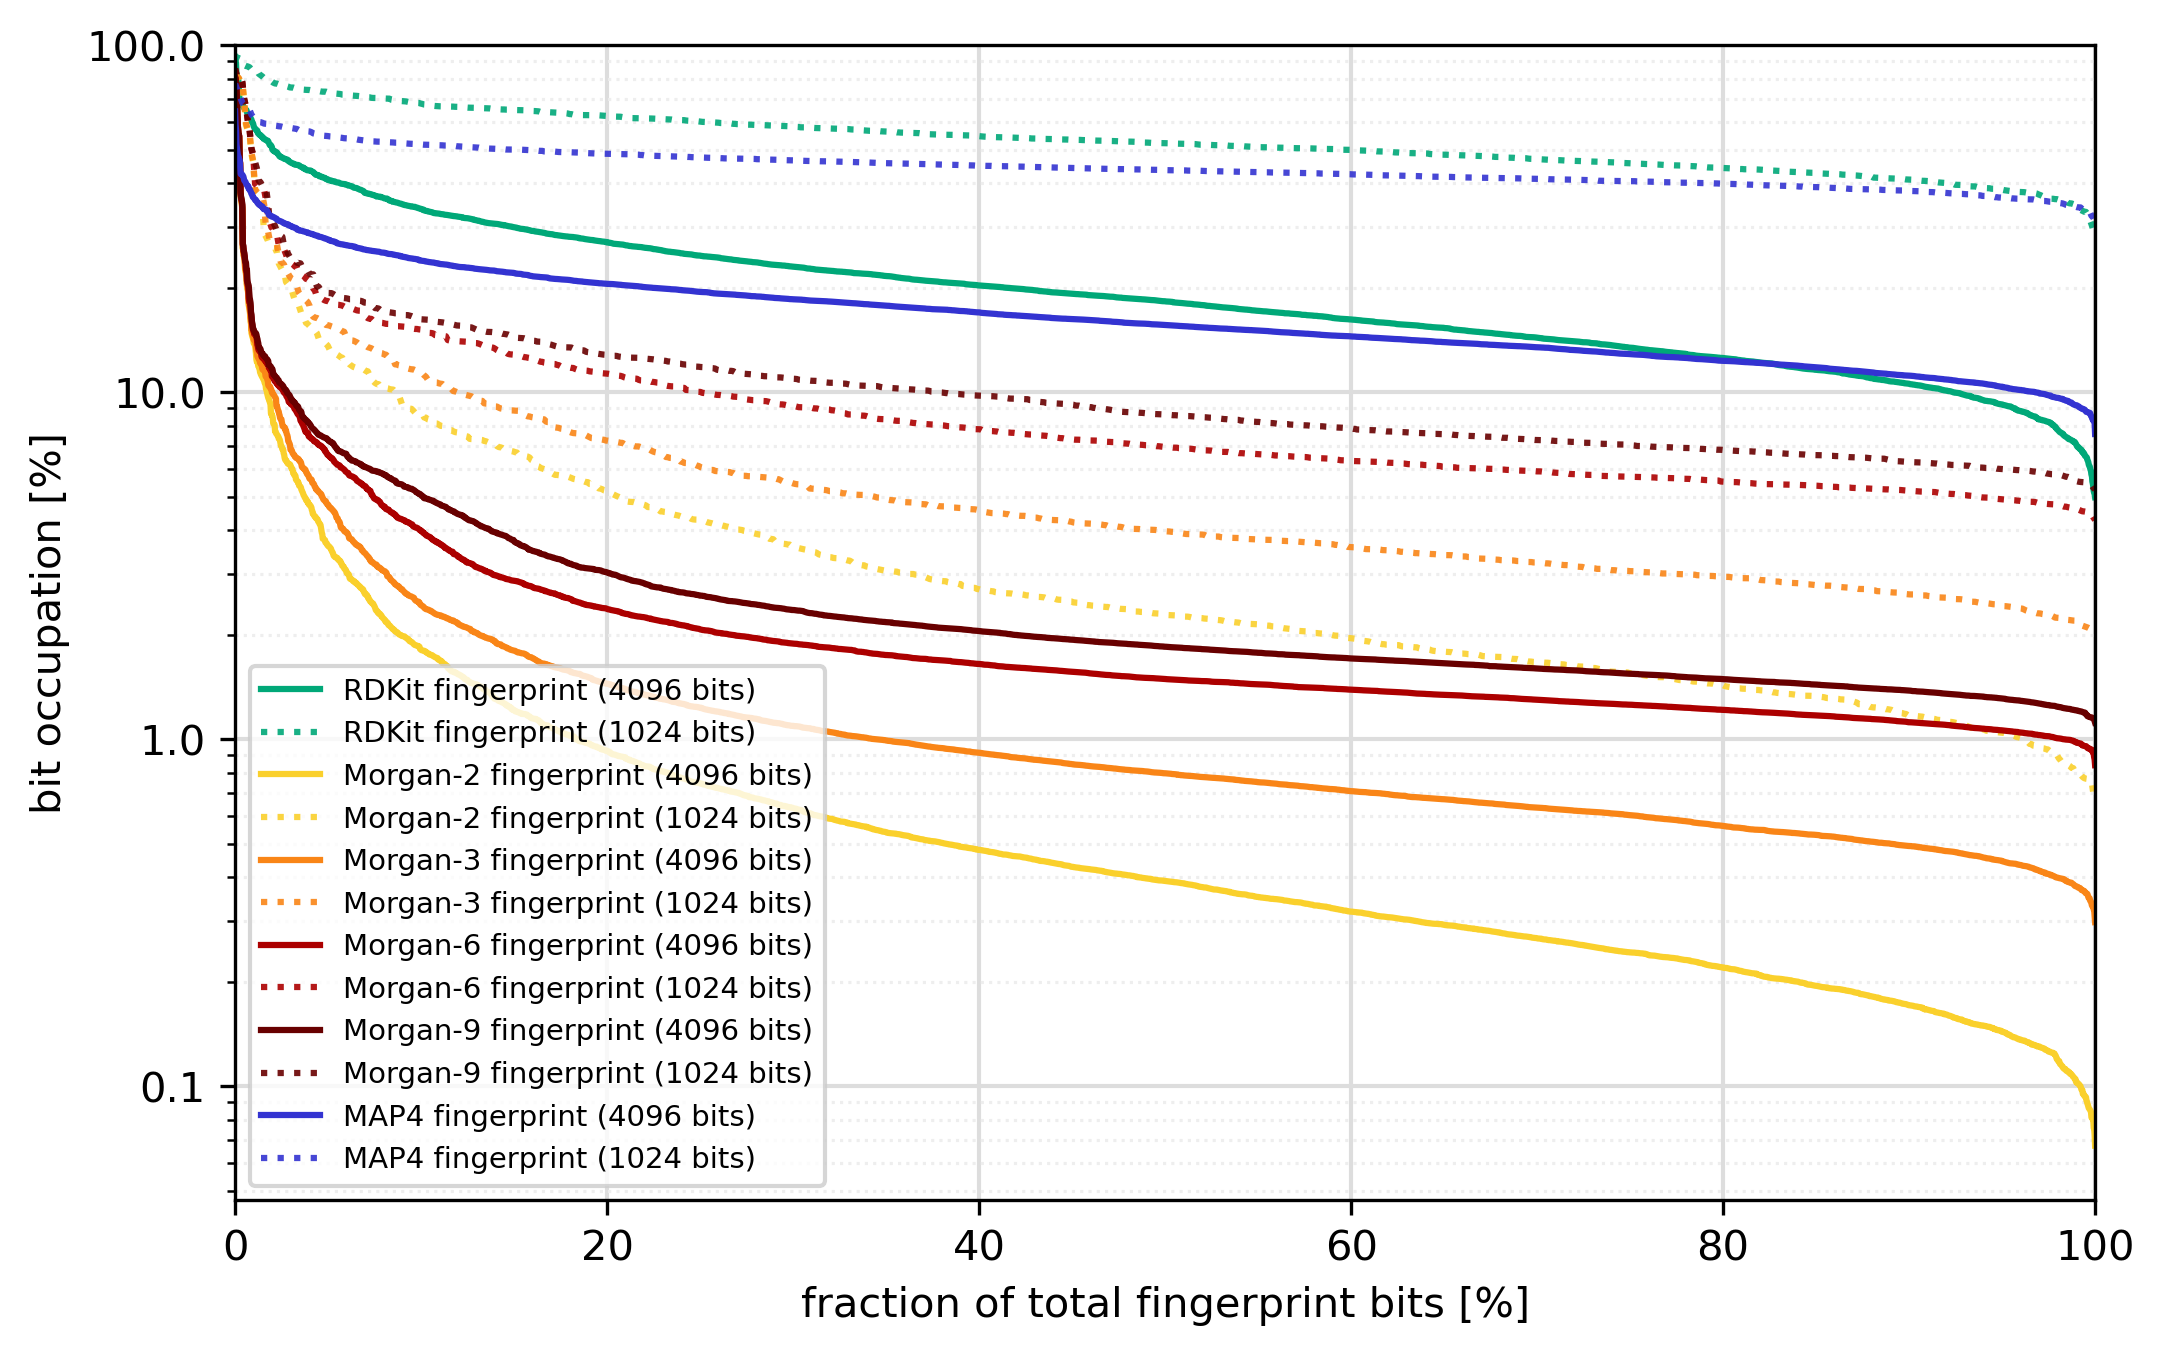

In [24]:
from matplotlib.ticker import ScalarFormatter

plt.style.use('default')


fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

fig_i = -1
for i, (file, name) in enumerate(files_experiments):
    if "count" in name:
        if file[:7]+"_binary" in [x[0] for x in files_experiments]:
            continue
    fig_i += 1
    bins_occupied = np.load(os.path.join(path_results, f"{file}_bins_occupied.npy"))
    order = np.argsort(bins_occupied)[::-1]
    bins_scaled = np.linspace(0, 100, len(bins_occupied))


    if "1024" in name:
        ax.plot(bins_scaled, bins_occupied[order], ":", linewidth=1.5, color=colors[fig_i], alpha=0.9, label=name.replace(" count", ""))
    else:
        ax.plot(bins_scaled, bins_occupied[order], linewidth=1.5, color=colors[fig_i], label=name.replace(" count", ""))

ax.set_yscale("log")
ax.set_ylabel("bit occupation [%]")
ax.set_yticks([100, 10, 1, 0.1])
ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.set_xlabel("fraction of total fingerprint bits [%]")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Grid
ax.grid(which='major', color='#DDDDDD', linewidth=1)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.75)

plt.legend(fontsize=7)
plt.savefig("Bit_occupation_distributions_scaled_730k.pdf")
plt.savefig("Bit_occupation_distributions_scaled_730k.eps")
plt.savefig("Bit_occupation_distributions_scaled_730k.png", dpi=450)
plt.show()

In [ ]:
plt.style.use('ggplot')
#plt.style.use("fivethirtyeight")

In [26]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_count", "RDKit count fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("morgan4_count", "Morgan-4 count fingerprint (4096 bits)"),
    ("morgan5_count", "Morgan-5 count fingerprint (4096 bits)"),
    ("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("map4_4096", "MAP4 fingerprint (r=2, 4096 bits)")
]

## TAKE CARE: this will take the max difference per duplicates group
This is rather pessimistic, but might give an idea of the "risk" to find *very* different compounds for the same fingerprints.

After all 5 identical fingerprints with masses [200, 210, 350, 380, 500] would not all correspond to a max mass difference of 300.

In [27]:
def compute_compound_max_differences(masses):
    all_max_diffs = []
    min_mass = masses.min()
    max_mass = masses.max()
    for mass in masses:
        max_diff = max(mass - min_mass, max_mass - mass)
        all_max_diffs.append(max_diff)

    return np.array(all_max_diffs)

In [28]:
colors = ["#00A878", "#6CCD8C",
          "#E6D98C", "#F1C178",
          "#F16666", "#DD2222",
          ]

In [29]:
files_experiments = [
    ("rdkit", "RDKit fingerprint (4096 bits)"),
    ("rdkit_count", "RDKit count fingerprint (4096 bits)"),
    ("rdkit_1024", "RDKit fingerprint (1024 bits)"),
    ("morgan2_binary", "Morgan-2 fingerprint (4096 bits)"),
    ("morgan2_count", "Morgan-2 count fingerprint (4096 bits)"),
    ("morgan2_binary_1024", "Morgan-2 fingerprint (1024 bits)"),
    ("morgan3_binary", "Morgan-3 fingerprint (4096 bits)"),
    ("morgan3_count", "Morgan-3 count fingerprint (4096 bits)"),
    ("morgan3_binary_1024", "Morgan-3 fingerprint (1024 bits)"),
    ("morgan6_count", "Morgan-6 count fingerprint (4096 bits)"),
    ("morgan6_binary", "Morgan-6 fingerprint (4096 bits)"),
    ("morgan6_binary_1024", "Morgan-6 fingerprint (1024 bits)"),
    ("morgan9_count", "Morgan-9 count fingerprint (4096 bits)"),
    #("map2", "MAP2 fingerprint (4096 bits)"),
    ("map4", "MAP4 fingerprint (4096 bits)"),
    ("map4_1024", "MAP4 fingerprint (1024 bits)"),
    #("biosynphoni", "Biosynfoni fingerprint"),
]

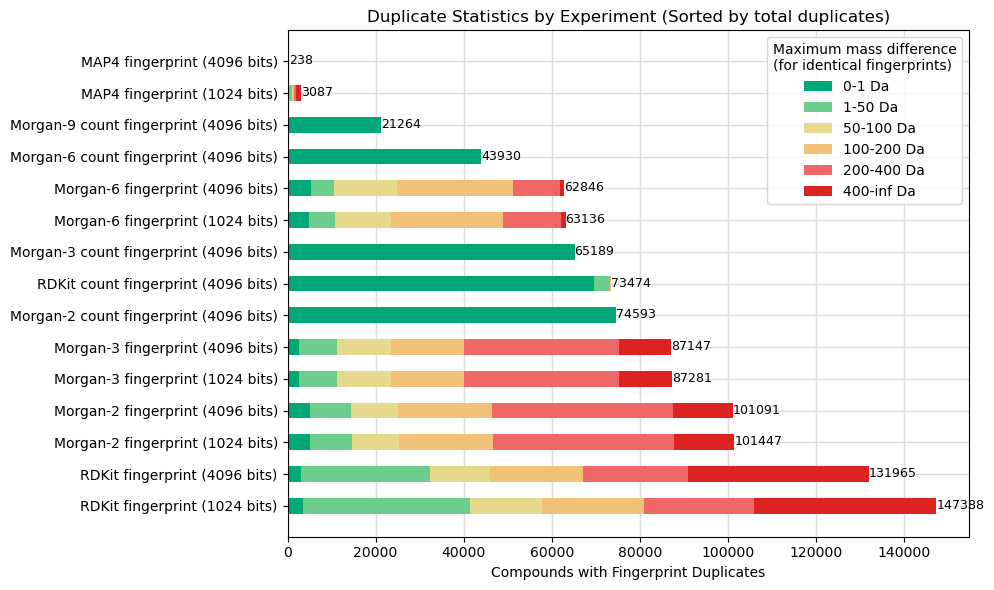

In [31]:
# Define the bins
bins = [(0, 1), (1, 50), (50, 100), (100, 200), (200, 400), (400, np.inf)]
bin_labels = [f"{low}-{high} Da" if high != np.inf else f"{low}-inf Da" for low, high in bins]


# Initialize results storage
experiment_sums = {name: np.zeros(len(bins)) for _, name in files_experiments}

# Process each experiment
for file, name in files_experiments:
    # Load duplicates data
    with open(os.path.join(path_results, f"{file}_duplicates.pickle"), "rb") as f:
        duplicates = pickle.load(f)

    # Calculate statistics
    duplicate_statistics = np.array([len(x) for x in duplicates])
    duplicate_masses = [masses[i] for i in duplicates]
    max_mass_differences = np.concatenate([compute_compound_max_differences(x) for x in duplicate_masses])

    # Compute sums for each bin
    for i, (low, high) in enumerate(bins):
        idx = np.where((max_mass_differences >= low) & (max_mass_differences < high))[0]
        experiment_sums[name][i] = idx.shape[0]

# Sort experiments by total sum
sorted_experiments = sorted(
    experiment_sums.items(), 
    key=lambda item: item[1].sum(), 
    reverse=True
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare for stacked bar chart
width = 0.5
y_positions = np.arange(len(sorted_experiments))
left_stack = np.zeros(len(sorted_experiments))

# Iterate over bins and stack their sums
for i, label in enumerate(bin_labels):
    values = [experiment[1][i] for experiment in sorted_experiments]
    ax.barh(y_positions, values, width, label=label, left=left_stack, color=colors[i])
    left_stack += values

# Add numbers
for i, y in enumerate(y_positions):
    value = sorted_experiments[i][1].sum()
    plt.text(value, i-0.1, f"{value:.0f}", fontsize=9)

ax.set_axisbelow(True)
ax.grid(which='major', color='#DDDDDD', linewidth=1)

# Configure plot appearance
ax.set_yticks(y_positions)
ax.set_yticklabels([experiment[0] for experiment in sorted_experiments])
ax.set_xlabel("Compounds with Fingerprint Duplicates")
ax.set_title("Duplicate Statistics by Experiment (Sorted by total duplicates)")
ax.legend(title="Maximum mass difference\n(for identical fingerprints)", loc="upper right")


plt.tight_layout()
plt.savefig("Duplicate_statistics_max_mass_difference_730k.pdf")
plt.savefig("Duplicate_statistics_max_mass_difference_730k.png", dpi=600)
plt.show()
